In [1]:
# Importing Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Loading Data from Amazon S3 bucket using Spark

In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()


Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,776 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,058 kB]
Get:14 http://

In [3]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [4]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
sales_url = "https://car-sales-data-group2.s3.amazonaws.com/vehicles.csv"
spark.sparkContext.addFile(sales_url)
car_sales_df = spark.read.csv(SparkFiles.get("vehicles.csv"), sep=",", header=True)

# Show the sales data.
car_sales_df.show()

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [5]:
df = car_sales_df.toPandas()


#Exploratory Data Analysis (EDA)

In [6]:
# Display number of rows and columns in the data
df.shape


(441802, 26)

In [7]:
# Retrieve column names
df.columns


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [8]:
# Check number of null values in each column
df.isna().sum()


id                   0
url               9884
region            6901
region_url        6533
price             6446
year              7890
manufacturer     28937
model            17506
condition       187143
cylinders       190798
fuel             16344
odometer         17801
title_status     21618
transmission     15932
VIN             174486
drive           144178
size            319997
type            106892
paint_color     143839
image_url        13732
description      13733
county          382283
state            23077
lat              25397
long             24715
posting_date     22477
dtype: int64

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441802 entries, 0 to 441801
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            441802 non-null  object
 1   url           431918 non-null  object
 2   region        434901 non-null  object
 3   region_url    435269 non-null  object
 4   price         435356 non-null  object
 5   year          433912 non-null  object
 6   manufacturer  412865 non-null  object
 7   model         424296 non-null  object
 8   condition     254659 non-null  object
 9   cylinders     251004 non-null  object
 10  fuel          425458 non-null  object
 11  odometer      424001 non-null  object
 12  title_status  420184 non-null  object
 13  transmission  425870 non-null  object
 14  VIN           267316 non-null  object
 15  drive         297624 non-null  object
 16  size          121805 non-null  object
 17  type          334910 non-null  object
 18  paint_color   297963 non

In [11]:
# Drop unnecessary columns
df.drop(['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'size'], axis=1, inplace=True)


In [12]:
# Calculate percentage of null values in each column
df.isna().sum()/df.shape[0]*100


region           1.562012
price            1.459025
year             1.785868
manufacturer     6.549767
model            3.962408
condition       42.359021
cylinders       43.186314
fuel             3.699395
odometer         4.029180
title_status     4.893142
transmission     3.606140
drive           32.634076
type            24.194549
paint_color     32.557345
state            5.223381
posting_date     5.087573
dtype: float64

In [13]:
# Drop rows with null values in key columns
df = df.dropna(subset=['year', 'odometer', 'manufacturer', 'model'])

In [14]:
# Enter unknown for null values in remaining columns to keep more rows of data
df.fillna('unknown', inplace=True)


Handling duplicated values


In [15]:
# Count duplicated rows
df.duplicated().sum()


10886

In [16]:
# Drop duplicated rows
df = df.drop_duplicates()


In [17]:
# Display number of rows and columns remaining
df.shape


(390518, 16)

In [18]:
# Collect unique values in manufacturer column by count
manufacturer_values = df['manufacturer'].value_counts()


In [19]:
# Display collected values
print(manufacturer_values)


ford                                                             67827
chevrolet                                                        52023
toyota                                                           32677
honda                                                            20547
nissan                                                           18254
jeep                                                             18129
ram                                                              16476
gmc                                                              15774
bmw                                                              14259
dodge                                                            13017
mercedes-benz                                                    11210
hyundai                                                           9940
subaru                                                            9118
volkswagen                                                        9008
kia   

In [20]:
# Keep top 20 manufacturers and change remaining values to 'others' to simplify column
df['manufacturer'] = df['manufacturer'].apply(lambda x: x if str(x) in manufacturer_values[:20] else 'others')


In [21]:
# Collect and display unique values in region column by count
region_values = df['region'].value_counts()
print(region_values)

columbus                 3252
jacksonville             3178
grand rapids             2844
sacramento               2841
minneapolis / st paul    2838
                         ... 
gti                         1
 sin crédito                1
 low miles                  1
 any finance charges        1
 2011                       1
Name: region, Length: 416, dtype: int64


In [22]:
# Keep top 50 regions and change remaining values to 'others' to simplify column
df['region'] = df['region'].apply(lambda x: x if str(x) in region_values[:50] else 'others')

In [23]:
# Collect and display unique values in model column by count
model_values = df['model'].value_counts()

In [ ]:
# Keep top 50 models and change remaining values to 'others' to simplify column
df['model'] = df['model'].apply(lambda x: x if str(x) in model_values[:50] else 'others')

In [24]:
# Aggregate different names for the same model under one name 
df.loc[df['model'] == 'f150', 'model'] = 'f-150'
df.loc[df['model'] == 'silverado 1500', 'model'] = 'silverado'
df.loc[df['model'] == 'silverado 2500hd', 'model'] = 'silverado'
df.loc[df['model'] == 'sierra 1500', 'model'] = 'sierra'
df.loc[df['model'] == 'wrangler unlimited', 'model'] = 'wrangler'

In [25]:
df.loc[(df['model'] == '1500') & (df['manufacturer'] == 'chevrolet'), 'model'] = 'silverado'
df.loc[(df['model'] == '2500') & (df['manufacturer'] == 'chevrolet'), 'model'] = 'silverado'
df.loc[(df['model'] == '3500') & (df['manufacturer'] == 'chevrolet'), 'model'] = 'silverado'

In [26]:
df.loc[df['manufacturer'] == 'ram', 'manufacturer'] = 'dodge'
df.loc[(df['model'] == '1500') & (df['manufacturer'] == 'dodge'), 'model'] = 'ram 1500'
df.loc[(df['model'] == '2500') & (df['manufacturer'] == 'dodge'), 'model'] = 'ram 2500'
df.loc[(df['model'] == '3500') & (df['manufacturer'] == 'dodge'), 'model'] = 'ram 3500'


In [27]:
# Check model column to verify the same models are under one name
df['model'].value_counts()

others            291521
silverado           9513
f-150               8644
wrangler            3941
ram 1500            3769
camry               2986
accord              2841
sierra              2752
civic               2743
altima              2671
escape              2669
tacoma              2417
explorer            2405
grand cherokee      2398
ram 2500            2368
mustang             2157
corolla             2090
equinox             1881
fusion              1861
cr-v                1857
focus               1765
malibu              1659
charger             1640
sonata              1631
corvette            1628
tahoe               1626
rav4                1622
impala              1621
grand caravan       1559
cruze               1496
outback             1469
odyssey             1454
f-250               1438
elantra             1428
edge                1419
prius               1366
tundra              1348
jetta               1328
ram 3500            1294
forester            1286


In [28]:
# Create states list to filter data with
states_list = [ 'ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
           'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
           'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
           'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
           'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

In [29]:
# Keep 51 actual states and change remaining values to 'others' to simplify column
df['state'] = df['state'].apply(lambda x: x if str(x) in states_list[:51] else 'others')

In [30]:
# Remove rows with 'None' value in posting date column
df = df.loc[df['posting_date'] != 'None']

In [31]:
# Display values in posting date column
df['posting_date'].value_counts()

unknown                                                                                                                                                                 5873
 7.3L Powerstroke Diesels                                                                                                                                               4184
 you may need help.\t\t\t \t\t\t\t\t\t \t\t\tWe put our bottom line lowest price on every pre-owned vehicle and then let you decide if                                  2815
 Registration Fees                                                                                                                                                       906
 or processing fee. Please see a salesperson with any questions you might have before making any purchase commitment on this or any other vehicle we have for sale."     794
                                                                                                                                       

In [32]:
# Change posting date to datetime format and coerce non-datetime values to nulls
import datetime

df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')


In [33]:
# Display values in posting date column to verify conversion
df['posting_date'].value_counts()[:30]

2009-01-01 00:00:00          126
2010-01-01 00:00:00           84
2014-01-01 00:00:00           74
2013-01-01 00:00:00           69
2011-01-01 00:00:00           49
2018-01-01 00:00:00           35
2015-01-01 00:00:00           33
2016-01-01 00:00:00           28
2017-01-01 00:00:00           26
2019-01-01 00:00:00           21
2012-01-01 00:00:00           18
2007-01-01 00:00:00           15
2022-01-01 00:00:00           14
2021-04-23 19:13:05-07:00     13
2021-04-30 10:01:13-04:00     12
2021-04-13 13:19:15-05:00     11
2021-05-04 09:00:42-06:00     11
2021-04-08 11:07:39-04:00     11
2002-01-01 00:00:00           11
2021-05-03 06:41:54-07:00     11
2021-05-01 07:01:20-07:00     11
2021-04-29 16:25:19-04:00     11
2021-05-01 10:01:07-07:00     10
2021-04-30 11:51:02-07:00     10
2021-05-03 07:41:08-07:00      9
2021-04-29 16:25:47-04:00      9
2021-05-03 15:32:03-05:00      9
2021-05-04 12:01:13-05:00      9
2021-04-26 16:40:44-05:00      9
2021-04-27 15:34:58-04:00      9
Name: post

In [34]:
# Drop coerced null values from posting date column
df = df.dropna(subset=['posting_date'])
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,2021-05-04 12:31:18-05:00
28,others,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,2021-05-04 12:31:08-05:00
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,2021-05-04 12:31:25-05:00
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,2021-05-04 10:41:31-05:00
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,2021-05-03 14:02:03-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown,wy,2021-04-04 03:21:31-06:00
441798,others,30590,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red,wy,2021-04-04 03:21:29-06:00
441799,others,34990,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white,wy,2021-04-04 03:21:17-06:00
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy,2021-04-04 03:21:11-06:00


In [35]:
# Display number of unique values in each column
for i in df.columns:
  print(i, len(df[i].value_counts().index))

region 51
price 12631
year 106
manufacturer 20
model 49
condition 7
cylinders 9
fuel 6
odometer 89251
title_status 7
transmission 4
drive 4
type 14
paint_color 13
state 52
posting_date 269842


In [38]:
# Change price column to integer and coerce non numeric values to nulls
df['price'] = pd.to_numeric(df['price'], errors='coerce')


In [39]:
# Drop coerced null values
df = df.dropna(subset=['price'])
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,2021-05-04 12:31:18-05:00
28,others,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,2021-05-04 12:31:08-05:00
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,2021-05-04 12:31:25-05:00
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,2021-05-04 10:41:31-05:00
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,2021-05-03 14:02:03-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown,wy,2021-04-04 03:21:31-06:00
441798,others,30590,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red,wy,2021-04-04 03:21:29-06:00
441799,others,34990,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white,wy,2021-04-04 03:21:17-06:00
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy,2021-04-04 03:21:11-06:00


# Numerical Data Cleaning



In [40]:
# Display statistics for price column
df.describe()

,price
count,3.392160e+05
mean,7.017696e+04
std,1.226951e+07
min,0.000000e+00
25%,5.990000e+03
50%,1.345000e+04
75%,2.559000e+04
max,3.736929e+09


Removing Outliers

In [41]:
# Calculate quartiles and interquartile range for price
price_percentile25 = df['price'].quantile(0.25)
price_percentile75 = df['price'].quantile(0.75)
price_iqr = price_percentile75 - price_percentile25

In [42]:
# Set upper and lower limit for price
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = df['price'].quantile(0.15)

In [43]:
# Remove outliers and create new dataframe
new_df = df[(df['price'] < price_upper_limit) & (df['price'] > price_lower_limit)]

In [44]:
# Change year and odometer columns to integer and float respectively and coerce non numeric values to nulls
# Drop coerced null values
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce')
new_df = new_df.dropna(subset=['year'])
new_df['year'] = new_df['year'].astype(int)

new_df['odometer'] = pd.to_numeric(new_df['odometer'], errors='coerce')
new_df = new_df.dropna(subset=['odometer'])
new_df['odometer'] = new_df['odometer'].astype(float)

<ipython-input-44-027208018140>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce')


In [45]:
# Calculate quartiles and interquartile range for odometer
# Set upper and lower limit for odometer
odometer_percentile75 = new_df['odometer'].quantile(0.75)
odometer_percentile25 = new_df['odometer'].quantile(0.25)
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = new_df['odometer'].quantile(0.05)

In [46]:
# Display statistics for numeric columns
new_df.describe()


,price,year,odometer
count,281636.000000,281636.000000,2.816360e+05
mean,18772.114744,2011.738251,9.290991e+04
std,11756.155533,8.482231,1.442411e+05
min,3525.000000,1900.000000,0.000000e+00
25%,8500.000000,2009.000000,3.705600e+04
50%,15995.000000,2013.000000,8.511000e+04
75%,26997.000000,2017.000000,1.312192e+05
max,54989.000000,2022.000000,1.000000e+07


In [48]:
# Remove outliers for odometer
new_df = new_df[(new_df['odometer'] < odometer_upper_limit) & (new_df['odometer'] > odometer_lower_limit)]


In [49]:
# Display number or rows and columns in the new dataframe
new_df.shape

(265482, 16)

In [50]:
# Display sample of new dataframe
new_df.sample(5)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
280725,long island,35000,2020,ford,others,like new,6 cylinders,gas,50395.0,clean,automatic,rwd,van,white,ny,2021-05-02 22:09:49-04:00
64203,SF bay area,21981,2018,toyota,camry,unknown,4 cylinders,gas,34205.0,clean,automatic,fwd,sedan,white,ca,2021-05-02 16:33:09-07:00
196144,others,10995,2011,honda,others,unknown,unknown,gas,106000.0,clean,automatic,unknown,unknown,unknown,ma,2021-05-03 22:19:51-04:00
352143,others,13500,2010,jeep,wrangler,good,unknown,gas,123000.0,clean,automatic,4wd,unknown,red,pa,2021-04-20 15:34:24-04:00
229730,others,8500,2011,toyota,camry,excellent,4 cylinders,gas,157963.0,clean,automatic,fwd,sedan,white,mo,2021-04-16 17:05:19-05:00


In [51]:
# Check data types of columns in new dataframe
new_df.dtypes

region           object
price             int64
year              int64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
type             object
paint_color      object
state            object
posting_date     object
dtype: object

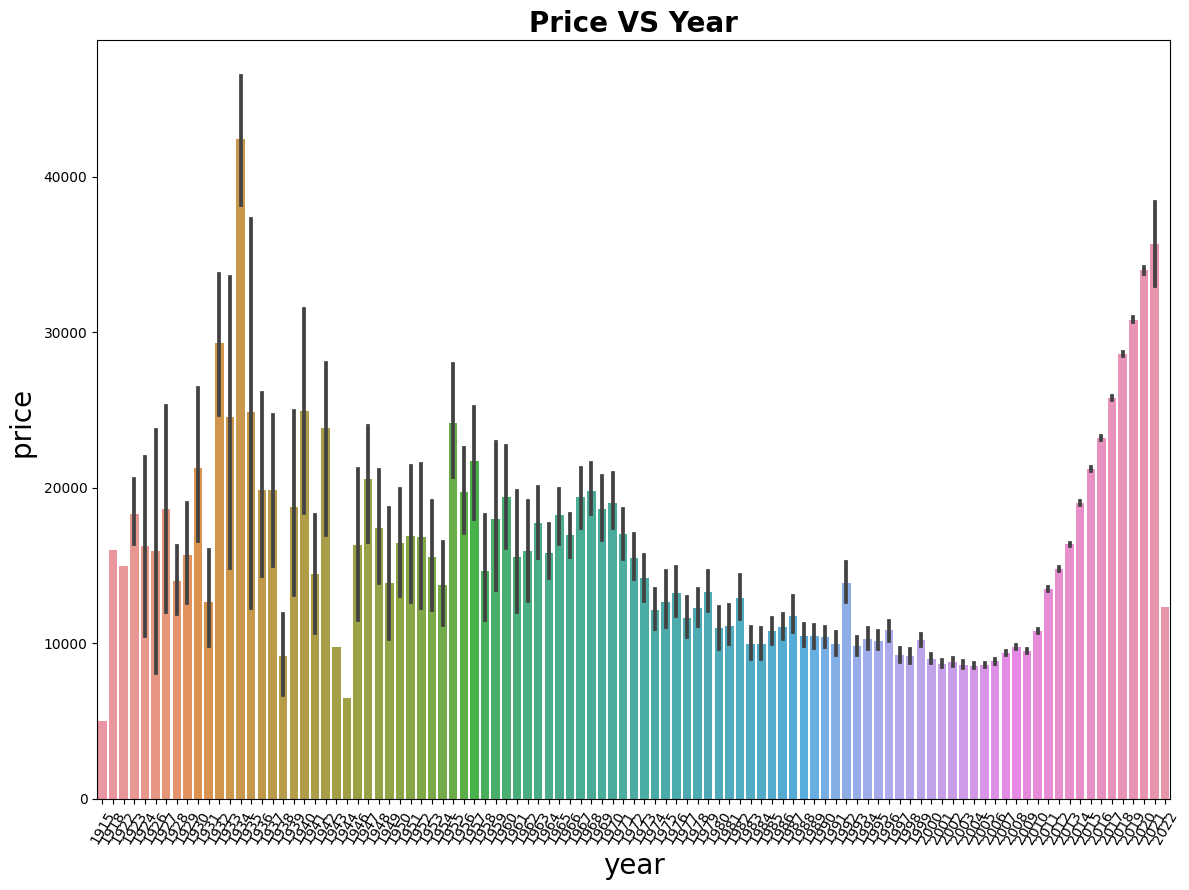

In [52]:
# Plot Price vs Car Year
plt.rcParams["figure.autolayout"] = True
sns.set_palette('summer_r')
plt.figure(figsize =(12,9))
sns.barplot(y=new_df['price'],x=new_df['year'])
plt.title("Price VS Year",fontsize=20,fontweight ='bold')
plt.xlabel('year',fontsize = 20)
plt.xticks(rotation=60)
plt.ylabel('price ',fontsize = 20)
plt.tight_layout()
plt.show()

In [53]:
# Remove cars manufactured before 1993 to simplify data and remove classic/vintage effect on price
# Check number of rows and columns
new_df = new_df[new_df['year'] > 1993]
new_df.shape


(258900, 16)

In [54]:
# Check the range of year values to verify
new_df['year'].value_counts()

2018    23709
2017    23641
2013    21863
2014    20768
2015    20301
2016    19404
2012    17341
2011    14841
2019    13747
2008    11866
2010    11455
2007     9785
2009     8726
2006     7816
2020     7560
2005     6300
2004     5091
2003     3796
2002     2698
2001     2039
2000     1569
1999     1302
1998      788
1997      722
1995      603
1996      597
1994      441
2021      130
2022        1
Name: year, dtype: int64

In [55]:
# Create posting year column from posting date
# Display dataframe to verify column creation
new_df['posting_date'] = pd.to_datetime(new_df['posting_date'], utc=True)
new_df['posting_year'] = new_df['posting_date'].dt.strftime('%Y')

new_df


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,posting_year
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white,al,2021-05-04 17:31:18+00:00,2021
28,others,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,al,2021-05-04 17:31:08+00:00,2021
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red,al,2021-05-04 17:31:25+00:00,2021
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red,al,2021-05-04 15:41:31+00:00,2021
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03 19:02:03+00:00,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441796,others,33590,2018,lexus,others,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy,2021-04-04 09:21:34+00:00,2021
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,2021-04-04 09:21:31+00:00,2021
441798,others,30590,2020,others,others,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,2021-04-04 09:21:29+00:00,2021
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,2021-04-04 09:21:11+00:00,2021


In [56]:
# Check posting years
new_df['posting_year'].value_counts()

2021    258489
2013        62
2014        52
2015        32
2011        29
2018        29
2010        28
2016        27
2017        26
2009        20
2019        18
2012        18
2007        15
2002        11
2022        10
2020         9
1996         5
2004         4
1995         4
2005         2
2003         2
2008         2
2006         2
1997         1
2032         1
1998         1
1992         1
Name: posting_year, dtype: int64

In [57]:
# Remove bad data
new_df = new_df.loc[new_df['posting_year'] != '2032']

In [59]:
# Verify bad data is removed
new_df['posting_year'].value_counts()

2021    258489
2013        62
2014        52
2015        32
2011        29
2018        29
2010        28
2016        27
2017        26
2009        20
2019        18
2012        18
2007        15
2002        11
2022        10
2020         9
1996         5
2004         4
1995         4
2003         2
2005         2
2008         2
2006         2
1997         1
1998         1
1992         1
Name: posting_year, dtype: int64

In [60]:
# Check data types for columns to see posting year data type
new_df.dtypes

region                       object
price                         int64
year                          int64
manufacturer                 object
model                        object
condition                    object
cylinders                    object
fuel                         object
odometer                    float64
title_status                 object
transmission                 object
drive                        object
type                         object
paint_color                  object
state                        object
posting_date    datetime64[ns, UTC]
posting_year                 object
dtype: object

In [61]:
# Change posting year data type to integer
new_df['posting_year'] = new_df['posting_year'].astype(int)

<ipython-input-61-dd5936292a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['posting_year'] = new_df['posting_year'].astype(int)


In [62]:
# Verify data type is changed
new_df.dtypes

region                       object
price                         int64
year                          int64
manufacturer                 object
model                        object
condition                    object
cylinders                    object
fuel                         object
odometer                    float64
title_status                 object
transmission                 object
drive                        object
type                         object
paint_color                  object
state                        object
posting_date    datetime64[ns, UTC]
posting_year                  int64
dtype: object

In [63]:
# Calculate age of car at the time of craiglist posting and create new column for car age
# Display data frame to verify new column
new_df['car_age'] = new_df['posting_year'] - new_df['year']
new_df

<ipython-input-63-4408ca9ead24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['car_age'] = new_df['posting_year'] - new_df['year']


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,posting_year,car_age
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white,al,2021-05-04 17:31:18+00:00,2021,7
28,others,22590,2010,chevrolet,silverado,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,al,2021-05-04 17:31:08+00:00,2021,11
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red,al,2021-05-04 17:31:25+00:00,2021,1
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red,al,2021-05-04 15:41:31+00:00,2021,4
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03 19:02:03+00:00,2021,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441796,others,33590,2018,lexus,others,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy,2021-04-04 09:21:34+00:00,2021,3
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,2021-04-04 09:21:31+00:00,2021,2
441798,others,30590,2020,others,others,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,2021-04-04 09:21:29+00:00,2021,1
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,2021-04-04 09:21:11+00:00,2021,3


In [64]:
# Display values in car age column
new_df['car_age'].value_counts()

 3     23707
 4     23595
 8     21828
 7     20726
 6     20257
 5     19363
 9     17325
 10    14815
 2     13738
 13    11862
 11    11450
 14     9781
 12     8722
 15     7811
 1      7554
 16     6299
 17     5087
 18     3796
 19     2698
 20     2036
 21     1569
 22     1302
 23      781
 24      722
 26      603
 25      597
 27      441
 0       162
-4       119
-1        52
-2        44
-5        10
-3        10
-6         8
-7         4
-8         4
-9         4
-10        3
-11        3
-21        2
-24        2
-12        2
-14        2
-15        1
-17        1
-13        1
Name: car_age, dtype: int64

In [65]:
# Remove rows with negative values
new_df = new_df.loc[new_df['car_age'] >= 0]

In [66]:
# Check bad data has been removed
new_df['car_age'].value_counts()

3     23707
4     23595
8     21828
7     20726
6     20257
5     19363
9     17325
10    14815
2     13738
13    11862
11    11450
14     9781
12     8722
15     7811
1      7554
16     6299
17     5087
18     3796
19     2698
20     2036
21     1569
22     1302
23      781
24      722
26      603
25      597
27      441
0       162
Name: car_age, dtype: int64

In [67]:
# Drop posting posting date, year and posting year columns now that car age column has been created and cleaned
# Check statistics for numerical columns in dataframe
new_df.drop(['posting_date'], axis = 1, inplace = True)
new_df.drop(['year'], axis = 1, inplace = True)
new_df.drop(['posting_year'], axis = 1, inplace = True)
new_df.describe()

<ipython-input-67-475fd224dd1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['posting_date'], axis = 1, inplace = True)
<ipython-input-67-475fd224dd1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['year'], axis = 1, inplace = True)
<ipython-input-67-475fd224dd1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['posting_year'], axis = 1, inplace = True)


,price,odometer,car_age
count,258627.000000,258627.000000,258627.000000
mean,18440.297262,93141.284243,8.384875
std,11529.679267,56790.048887,5.073075
min,3525.000000,7653.000000,0.000000
25%,8500.000000,42642.000000,4.000000
50%,15988.000000,89774.000000,8.000000
75%,26590.000000,133130.000000,11.000000
max,54988.000000,272412.000000,27.000000


In [68]:
# Export cleaned data to CSV
new_df.to_csv("final_car_sales.csv", index = False)

#Data Visualization

<ipython-input-69-a4ff67bfeb7b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(new_df.corr(), annot=True)


<Axes: >

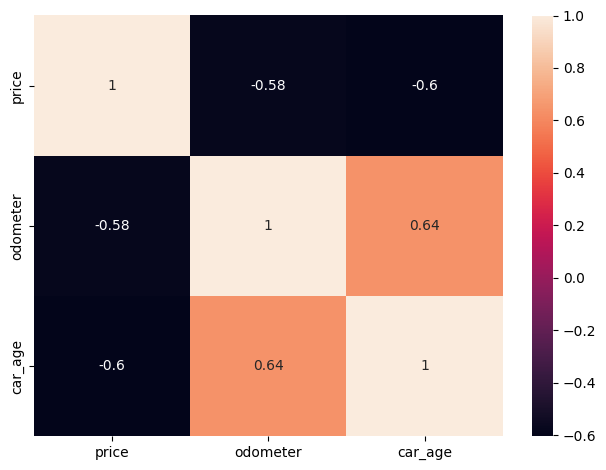

In [69]:
# Display correlation heatmap for numeric columns
sns.heatmap(new_df.corr(), annot=True)

In [70]:
# Display column names to verify columns in final CSV
new_df.columns


Index(['region', 'price', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'car_age'],
      dtype='object')

In [71]:
# Prepare copy of cleaned data for machine learning models
training_df = new_df.copy()

In [72]:
# Export to CSV for machine learning models
training_df.to_csv("training_df.csv", index = False)

#Machine Learning Models

In [73]:
# Read training data into pandas dataframe
import pandas as pd

training_df = pd.read_csv('/content/training_df.csv' )

In [74]:
# Drop the non-beneficial columns, 'region', 'paint_color' and 'title_status'.
training_df = training_df.drop(['region', 'paint_color', 'title_status'], axis=1)
training_df.head()

,price,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,state,car_age
0,33590,gmc,others,good,8 cylinders,gas,57923.0,other,unknown,pickup,al,7
1,22590,chevrolet,silverado,good,8 cylinders,gas,71229.0,other,unknown,pickup,al,11
2,39590,chevrolet,others,good,8 cylinders,gas,19160.0,other,unknown,pickup,al,1
3,30990,toyota,others,good,8 cylinders,gas,41124.0,other,unknown,pickup,al,4
4,15000,ford,others,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,al,8


In [75]:
# Convert categorical columns to numeric
numeric_dummies = pd.get_dummies(training_df)
numeric_dummies

,price,odometer,car_age,manufacturer_acura,manufacturer_audi,manufacturer_bmw,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,33590,57923.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22590,71229.0,11,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,39590,19160.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30990,41124.0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15000,128000.0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258622,33590,30814.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258623,23590,32226.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258624,30590,12029.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258625,28990,30112.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
# Collect names for all feature columns and remove target column
columns = numeric_dummies.columns.tolist()
columns.remove('price')
columns

['odometer',
 'car_age',
 'manufacturer_acura',
 'manufacturer_audi',
 'manufacturer_bmw',
 'manufacturer_cadillac',
 'manufacturer_chevrolet',
 'manufacturer_chrysler',
 'manufacturer_dodge',
 'manufacturer_ford',
 'manufacturer_gmc',
 'manufacturer_honda',
 'manufacturer_hyundai',
 'manufacturer_jeep',
 'manufacturer_kia',
 'manufacturer_lexus',
 'manufacturer_mercedes-benz',
 'manufacturer_nissan',
 'manufacturer_others',
 'manufacturer_subaru',
 'manufacturer_toyota',
 'manufacturer_volkswagen',
 'model_1500',
 'model_2500',
 'model_3500',
 'model_accord',
 'model_altima',
 'model_camaro',
 'model_camry',
 'model_charger',
 'model_civic',
 'model_corolla',
 'model_corvette',
 'model_cr-v',
 'model_cruze',
 'model_edge',
 'model_elantra',
 'model_equinox',
 'model_escape',
 'model_explorer',
 'model_f-150',
 'model_f-250',
 'model_f-350',
 'model_focus',
 'model_forester',
 'model_fusion',
 'model_grand caravan',
 'model_grand cherokee',
 'model_impala',
 'model_jetta',
 'model_mali

In [77]:
# Create separate arrays for feature and target columns
X = numeric_dummies[columns].values
y = numeric_dummies['price'].values.reshape(-1,1)
print(X.shape, y.shape)


(258627, 167) (258627, 1)


In [78]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [79]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [80]:
# Transform the training and testing data using the X_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [81]:
# Define function to calculate and store model performance scores
from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, mean_squared_log_error

def result(y_test, predictions):
    r=[]
    r.append('%.4f' % r2_score(y_test,predictions))
    r.append('%.4f' % (r2_score(y_test,predictions)*100))
    r.append('%.2f' % mean_squared_error(y_test, predictions))
    r.append('%.2f' % mean_absolute_error(y_test, predictions))
    r.append('%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))
    
    return (r)

#dataframe that store the performance of each model
score_data = pd.DataFrame(index=['R2 Score', 'Accuracy(%)', 'Mean Squared Error', 'Mean Absolute Error', 'Root MSE'])

In [82]:
# Create a LinearRegression model and fit it to the scaled training data
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)


In [83]:
# Calculating and recording model peformance
score_linear = result(y_test, predictions)
score_data['Linear Regression'] = score_linear
print('R2_score: ', score_linear[0])
print('Mean squared error: ', score_linear[2])
print('Mean absolute error: ', score_linear[3])
print('Root mean squared error: ', score_linear[4])

R2_score:  0.7403
Mean squared error:  34549047.32
Mean absolute error:  4398.06
Root mean squared error:  5877.84


In [84]:
 # LASSO model
# Note: Use an alpha of .01 when creating the model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train)

predictions = lasso.predict(X_test_scaled)     

In [85]:
# Calculating and recording model peformance
score_lasso = result(y_test, predictions)
score_data['Lasso Regression'] = score_lasso
print('R2_score: ', score_lasso[0])
print('Mean squared error: ', score_lasso[2])
print('Mean absolute error: ', score_lasso[3])
print('Root mean squared error: ', score_lasso[4])

R2_score:  0.7404
Mean squared error:  34544079.71
Mean absolute error:  4397.41
Root mean squared error:  5877.42


In [86]:
 # Ridge model
# Note: Use an alpha of .01 when creating the model
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train)

predictions = ridge.predict(X_test_scaled)

In [87]:
# Calculating and recording model peformance
score_ridge = result(y_test, predictions)
score_data['Ridge Regression'] = score_ridge
print('R2_score: ', score_ridge[0])
print('Mean squared error: ', score_ridge[2])
print('Mean absolute error: ', score_ridge[3])
print('Root mean squared error: ', score_ridge[4])

R2_score:  0.7404
Mean squared error:  34544089.32
Mean absolute error:  4397.41
Root mean squared error:  5877.42


In [88]:
 # ElasticNet model
# Note: Use an alpha of .01 when creating the model
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train)

predictions = elasticnet.predict(X_test_scaled)

In [89]:
# Calculating and recording model peformance
score_elasticnet = result(y_test, predictions)
score_data['Elastic Net Regression'] = score_elasticnet
print('R2_score: ', score_elasticnet[0])
print('Mean squared error: ', score_elasticnet[2])
print('Mean absolute error: ', score_elasticnet[3])
print('Root mean squared error: ', score_elasticnet[4])

R2_score:  0.7403
Mean squared error:  34546477.28
Mean absolute error:  4396.77
Root mean squared error:  5877.63


In [90]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=150,random_state=0, min_samples_leaf=1, max_features=0.3, n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [91]:
# Calculating and recording model peformance
score_rfr = result(y_test, predictions)
score_data['Random Forest Regression'] = score_rfr
print('R2 score: ', score_rfr[0])
print('Mean squared error: ', score_rfr[2])
print('Mean absolute error: ', score_rfr[3])
print('Root mean squared error: ', score_rfr[4])

R2 score:  0.9288
Mean squared error:  9475684.23
Mean absolute error:  1611.74
Root mean squared error:  3078.26


In [92]:
# Decision Tree Model
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# Create the decision tree regressor instance
model = tree.DecisionTreeRegressor()

# Fit the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [93]:
# Calculating and recording model peformance
score_decision = result(y_test, predictions)
score_data['Decision Tree Regression'] = score_decision
print('R2 score: ', score_decision[0])
print('Mean squared error: ', score_decision[2])
print('Mean absolute error: ', score_decision[3])
print('Root mean squared error: ', score_decision[4])

R2 score:  0.8666
Mean squared error:  17747292.34
Mean absolute error:  1896.94
Root mean squared error:  4212.75


In [94]:
# Display performance scores for each model
score_data

,Linear Regression,Lasso Regression,Ridge Regression,Elastic Net Regression,Random Forest Regression,Decision Tree Regression
R2 Score,0.7403,0.7404,0.7404,0.7403,0.9288,0.8666
Accuracy(%),74.0320,74.0357,74.0357,74.0339,92.8778,86.6606
Mean Squared Error,34549047.32,34544079.71,34544089.32,34546477.28,9475684.23,17747292.34
Mean Absolute Error,4398.06,4397.41,4397.41,4396.77,1611.74,1896.94
Root MSE,5877.84,5877.42,5877.42,5877.63,3078.26,4212.75


In [95]:
# Export model score data to CSV
score_data.to_csv('Model_peformance.csv')

Random Forest Regression is the best performing model. Changing parameters to see if accuracy can be improved

#Optimising the model

In [98]:
# Random Forest Model Optimisation - Increasing number of estimators
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=300 ,random_state=0, min_samples_leaf=1, max_features=0.3, n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [99]:
# Calculate and displat model peformance
print('R2 score: ', '%.4f' % r2_score(y_test,predictions))
print('Mean squared error: ', '%.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: ', '%.2f' % mean_absolute_error(y_test, predictions))
print('Root mean squared error: ', '%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))

R2 score:  0.9290
Mean squared error:  9442190.55
Mean absolute error:  1607.26
Root mean squared error:  3072.81


In [100]:
# Random Forest Model Optimisation - Setting max features to automatic
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=150 ,random_state=0, min_samples_leaf=1, max_features='auto', n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculate and displat model peformance
print('R2 score: ', '%.4f' % r2_score(y_test,predictions))
print('Mean squared error: ', '%.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: ', '%.2f' % mean_absolute_error(y_test, predictions))
print('Root mean squared error: ', '%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))

R2 score:  0.9231
Mean squared error:  10232632.90
Mean absolute error:  1646.27
Root mean squared error:  3198.85


In [101]:
# Random Forest Model Optimisation - Setting max features to square root of number of features
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=150 ,random_state=0, min_samples_leaf=1, max_features='sqrt', n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculate and displat model peformance
print('R2 score: ', '%.4f' % r2_score(y_test,predictions))
print('Mean squared error: ', '%.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: ', '%.2f' % mean_absolute_error(y_test, predictions))
print('Root mean squared error: ', '%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))

R2 score:  0.9253
Mean squared error:  9934296.46
Mean absolute error:  1758.89
Root mean squared error:  3151.87


In [102]:
# Random Forest Model Optimisation - Setting max features to the logarithim in base 2 of the number of features
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=150 ,random_state=0, min_samples_leaf=1, max_features='log2', n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculate and displat model peformance
print('R2 score: ', '%.4f' % r2_score(y_test,predictions))
print('Mean squared error: ', '%.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: ', '%.2f' % mean_absolute_error(y_test, predictions))
print('Root mean squared error: ', '%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))

R2 score:  0.9199
Mean squared error:  10658089.58
Mean absolute error:  1870.23
Root mean squared error:  3264.67


The best peforming Random Tree Regressor parameters:\
n_estimators=300\
random_state=0\
min_samples_leaf=1\
max_features=0.3\
n_jobs=-1\
oob_score=True

#Displaying the most important features

In [133]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=300,random_state=0, min_samples_leaf=1, max_features=0.3, n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

print('R2 score: ', '%.4f' % r2_score(y_test,predictions))
print('Mean squared error: ', '%.2f' % mean_squared_error(y_test, predictions))
print('Mean absolute error: ', '%.2f' % mean_absolute_error(y_test, predictions))
print('Root mean squared error: ', '%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))

R2 score:  0.9290
Mean squared error:  9442190.55
Mean absolute error:  1607.26
Root mean squared error:  3072.81


In [136]:
# Extract feature importances from model sort by descending importance and select the top 15
importances = rf_model.feature_importances_

feature_names = columns
feature_importances = pd.Series(importances, index=feature_names)

sorted_importances = feature_importances.sort_values(ascending=False)

sorted_importances_top15 = sorted_importances[:15]

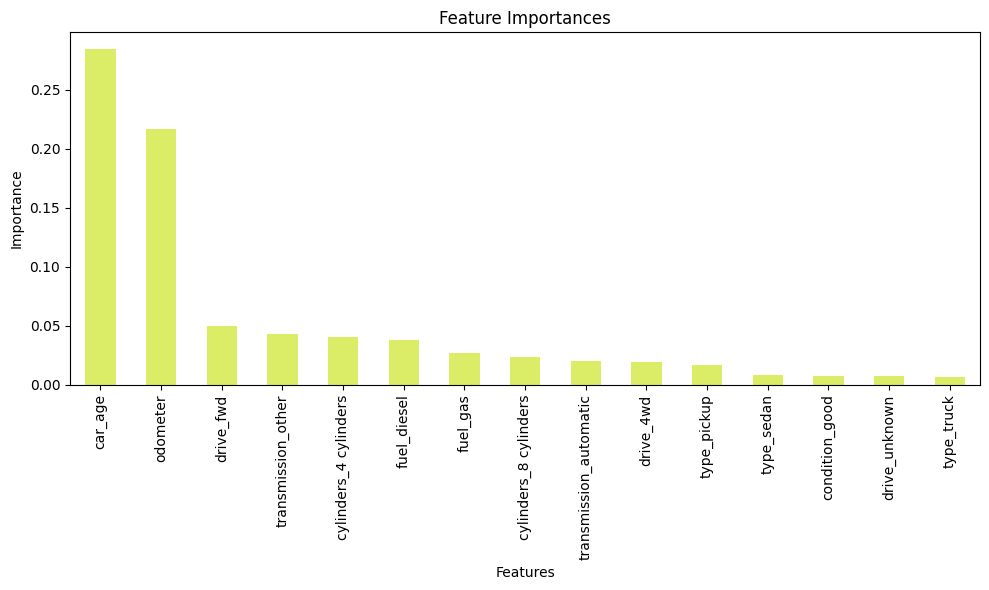

In [137]:
# Plot the top 15 most important features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_importances_top10.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

# Statistical tests for 5 of the most important features:
Car Age\
Odometer\
Drive\
Number of Cylinders\
Fuel

In [139]:
# Read training data csv into dataframe for statistical tests
stat_test_df = pd.read_csv('/content/training_df.csv' )

In [146]:
# Correlation for car age and price including R-squared and P-Value
from scipy.stats import linregress

x_values = stat_test_df['car_age']
y_values = stat_test_df['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"The r-value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

The r-value is: -0.6040623809163396
The r-squared is: 0.3648913600383169
The p-value is: 0.0


In [147]:
# Correlation for odometer and price including R-squared and P-Value
from scipy.stats import linregress

x_values = stat_test_df['odometer']
y_values = stat_test_df['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"The r-value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")

The r-value is: -0.5816809266015465
The r-squared is: 0.3383527003720337
The p-value is: 0.0


In [104]:
# Display unique values for drive category
stat_test_df['drive'].unique()

array(['unknown', 'rwd', '4wd', 'fwd'], dtype=object)

In [105]:
# Separate data into groups by different types of drive
drive_population = stat_test_df['price']
group_unknown_drive = stat_test_df[stat_test_df['drive'] == 'unknown']['price']
group_rwd_drive = stat_test_df[stat_test_df['drive'] == 'rwd']['price']
group_4wd_drive = stat_test_df[stat_test_df['drive'] == '4wd']['price']
group_fwd_drive = stat_test_df[stat_test_df['drive'] == 'fwd']['price']

In [106]:
# Anova Tests between different types of drive to see if there is any statisticaly siginificant difference in price among them
import scipy.stats as stats

stats.f_oneway(group_unknown_drive, group_rwd_drive, group_4wd_drive, group_fwd_drive)

F_onewayResult(statistic=8154.609146953132, pvalue=0.0)

P-Value is less than 0.05, the average price of at least 1 of the groups differs from that of another with statistical significance

In [107]:
# One sample T-test between unknown drive type price and population price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_unknown_drive, drive_population.mean())

TtestResult(statistic=19.205586048423193, pvalue=5.0782022916924896e-82, df=80422)

P-Value is less than 0.05, the average price of cars with no drive type mentioned differs from that of all the cars taken as a whole

In [108]:
# One sample T-test between rear wheel drive type price and population price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_rwd_drive, drive_population.mean())

TtestResult(statistic=36.66930571468746, pvalue=1.6164107024406855e-288, df=32681)

P-Value is less than 0.05, the average price of cars with rear wheel drive differs from that of all the cars taken as a whole

In [109]:
# One sample T-test between four wheel drive type price and population price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_4wd_drive, drive_population.mean())

TtestResult(statistic=67.52589764670944, pvalue=0.0, df=77163)

P-Value is less than 0.05, the average price of cars with four wheel drive differs from that of all the cars taken as a whole

In [110]:
# One sample T-test between front wheel drive type price and population price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_fwd_drive, drive_population.mean())

TtestResult(statistic=-186.99902446861032, pvalue=0.0, df=68357)

P-Value is less than 0.05, the average price of cars with front wheel drive differs from that of all the cars taken as a whole

In [111]:
# Display unique values for cylinders category
t_test_df['cylinders'].unique()

array(['8 cylinders', '6 cylinders', 'unknown', '4 cylinders',
       '5 cylinders', '10 cylinders', 'other', '3 cylinders',
       '12 cylinders'], dtype=object)

In [112]:
# Separate data into groups by number of engine cylinders
cylinder_population = stat_test_df['price']
group_unknown_cylinders = stat_test_df[stat_test_df['cylinders'] == 'unknown']['price']
group_other_cylinders = stat_test_df[stat_test_df['cylinders'] == 'other']['price']
group_3_cylinders = stat_test_df[stat_test_df['cylinders'] == '3 cylinders']['price']
group_4_cylinders = stat_test_df[stat_test_df['cylinders'] == '4 cylinders']['price']
group_5_cylinders = stat_test_df[stat_test_df['cylinders'] == '5 cylinders']['price']
group_6_cylinders = stat_test_df[stat_test_df['cylinders'] == '6 cylinders']['price']
group_8_cylinders = stat_test_df[stat_test_df['cylinders'] == '8 cylinders']['price']
group_10_cylinders = stat_test_df[stat_test_df['cylinders'] == '10 cylinders']['price']
group_12_cylinders = stat_test_df[stat_test_df['cylinders'] == '12 cylinders']['price']

In [113]:
# Anova Tests between different number of cylinders to see if there is any statisticaly siginificant difference in price among them

stats.f_oneway(group_unknown_cylinders, group_other_cylinders, group_3_cylinders, group_4_cylinders, group_5_cylinders,
               group_6_cylinders, group_8_cylinders, group_10_cylinders, group_12_cylinders)

F_onewayResult(statistic=3747.7818754004606, pvalue=0.0)

P-Value is less than 0.05, the average price of at least 1 of the groups differs from that of another with statistical significance

In [114]:
# One sample T-test between unknown cylinder number avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_unknown_cylinders, drive_population.mean())

TtestResult(statistic=45.16984409108229, pvalue=0.0, df=104897)

P-Value is less than 0.05, the average price of cars with an unlisted number of cylinders differs from that of all the cars taken as a whole

In [115]:
# One sample T-test between other cylinder number avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_other_cylinders, drive_population.mean())

TtestResult(statistic=-4.231232411522524, pvalue=2.9950187445455892e-05, df=339)

P-Value is less than 0.05, the average price of cars with an 'other' number of cylinders differs from that of all the cars taken as a whole

In [116]:
# One sample T-test between 3 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_3_cylinders, drive_population.mean())

TtestResult(statistic=-12.804185225985709, pvalue=4.430166780316896e-29, df=245)

P-Value is less than 0.05, the average price of cars with 3 engine cylinders differs from that of all the cars taken as a whole

In [117]:
# One sample T-test between 4 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_4_cylinders, drive_population.mean())

TtestResult(statistic=-237.36874618214134, pvalue=0.0, df=49360)

P-Value is less than 0.05, the average price of cars with 4 engine cylinders differs from that of all the cars taken as a whole

In [118]:
# One sample T-test between 5 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_5_cylinders, drive_population.mean())

TtestResult(statistic=-62.102196012931614, pvalue=0.0, df=1034)

P-Value is less than 0.05, the average price of cars with 5 engine cylinders differs from that of all the cars taken as a whole

In [119]:
# One sample T-test between 6 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_6_cylinders, drive_population.mean())

TtestResult(statistic=6.341942866772404, pvalue=2.2846504557938425e-10, df=61133)

P-Value is less than 0.05, the average price of cars with 6 engine cylinders differs from that of all the cars taken as a whole

In [120]:
# One sample T-test between 8 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_8_cylinders, drive_population.mean())

TtestResult(statistic=67.24027384734468, pvalue=0.0, df=40757)

P-Value is less than 0.05, the average price of cars with 8 engine cylinders differs from that of all the cars taken as a whole

In [121]:
# One sample T-test between 10 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_10_cylinders, drive_population.mean())

TtestResult(statistic=5.2712640814539125, pvalue=1.741646801228202e-07, df=805)

P-Value is less than 0.05, the average price of cars with 10 engine cylinders differs from that of all the cars taken as a whole

In [122]:
# One sample T-test between 12 cylinders avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_12_cylinders, drive_population.mean())

TtestResult(statistic=1.4824747815214676, pvalue=0.14475016469686203, df=48)

P-Value is less than 0.05, the average price of cars with 12 engine cylinders differs from that of all the cars taken as a whole

In [123]:
# Display unique values for fuel category
stat_test_df['fuel'].unique()

array(['gas', 'other', 'diesel', 'hybrid', 'unknown', 'electric'],
      dtype=object)

In [124]:
# Separate data into groups by type of fuel used
fuel_population = stat_test_df['fuel']
group_unknown_fuel = stat_test_df[stat_test_df['fuel'] == 'unknown']['price']
group_other_fuel = stat_test_df[stat_test_df['fuel'] == 'other']['price']
group_gas_fuel = stat_test_df[stat_test_df['fuel'] == 'gas']['price']
group_diesel_fuel = stat_test_df[stat_test_df['fuel'] == 'diesel']['price']
group_hybrid_fuel = stat_test_df[stat_test_df['fuel'] == 'hybrid']['price']
group_electric_fuel = stat_test_df[stat_test_df['fuel'] == 'electric']['price']

In [125]:
# Anova Tests between different fuel/car types to see if there is any statisticaly siginificant difference in price among them

stats.f_oneway(group_unknown_fuel, group_other_fuel, group_gas_fuel, group_diesel_fuel, group_hybrid_fuel, group_electric_fuel)

F_onewayResult(statistic=5787.657963924253, pvalue=0.0)

P-Value is less than 0.05, the average price of at least 1 of the groups differs from that of another with statistical significance

In [126]:
# One sample T-test between unknown fuel type avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_unknown_fuel, drive_population.mean())

TtestResult(statistic=4.454648515376429, pvalue=9.290258102562568e-06, df=1065)

P-Value is less than 0.05, the average price of cars with an unlisted fuel type differs from that of all the cars taken as a whole

In [127]:
# One sample T-test between other fuel type avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_other_fuel, drive_population.mean())

TtestResult(statistic=125.65746684592179, pvalue=0.0, df=21470)

P-Value is less than 0.05, the average price of cars with an other fuel type differs from that of all the cars taken as a whole

In [128]:
# One sample T-test between gas fuel type avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_gas_fuel, drive_population.mean())

TtestResult(statistic=-60.70328549602604, pvalue=0.0, df=218458)

P-Value is less than 0.05, the average price of gas fueled cars differs from that of all the cars taken as a whole

In [129]:
# One sample T-test between diesel fuel type avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_diesel_fuel, drive_population.mean())

TtestResult(statistic=88.3707671436103, pvalue=0.0, df=12680)

P-Value is less than 0.05, the average price of diesel fueled cars differs from that of all the cars taken as a whole

In [130]:
# One sample T-test between hybrid fuel type avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_hybrid_fuel, drive_population.mean())

TtestResult(statistic=-24.266198826755492, pvalue=5.0933510161389406e-121, df=3783)

P-Value is less than 0.05, the average price of hybrid fueled cars differs from that of all the cars taken as a whole

In [131]:
# One sample T-test between electric fuel type avg price and population avg price to see if there is a statisticaly siginificant difference
stats.ttest_1samp(group_electric_fuel, drive_population.mean())

TtestResult(statistic=18.34319588669807, pvalue=3.203379039629265e-66, df=1165)

P-Value is less than 0.05, the average price of electric fueled cars differs from that of all the cars taken as a whole